<center><b><font size="+2"> SISTEMA DE RECOMENDAÇÃO </font></b>


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
import matplotlib.pyplot as plt
from ast import literal_eval
import nltk
from nltk.stem import SnowballStemmer

df_movies = pd.read_csv(r'C:/Users/juliana/imbd_movies/movies_metadata.csv')
df_credits = pd.read_csv(r'C:/Users/juliana/imbd_movies/credits.csv')
df_keywords = pd.read_csv(r'C:/Users/juliana/imbd_movies/keywords.csv')
links_small = pd.read_csv(r'C:/Users/juliana/imbd_movies/links_small.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
def removeTextRows(df, columnName):
    index_0=[]
    
    for i in df.itertuples():
        myValue = getattr(i, columnName)
        if(str.isdigit(myValue)):
            index_0.append(i.Index)

    df=df.loc[index_0] 
    df.reset_index(level=0, inplace=True)
    return df   

def weightedRating(x, m, C):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

def getRecommendations(title, cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return df_movies['title'].iloc[movie_indices]

def getDirector(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

def filterKeywords(y):
    words = []
    for i in x:
        if i in y:
            words.append(i)
    return words

In [3]:
df_movies['id'] = df_movies['id'].astype('string')
df_movies['budget'] = df_movies['budget'].astype('string')
df_movies = removeTextRows(df_movies,'budget')
df_movies['budget']=pd.to_numeric(df_movies['budget'])
df_movies['popularity']=pd.to_numeric(df_movies['popularity'])

df_credits['id'] = df_credits['id'].astype('string')
df_movies = df_movies.merge(df_credits, on='id')

C= df_movies['vote_average'].mean()
m= df_movies['vote_count'].quantile(0.9)

q_movies = df_movies.copy().loc[df_movies['vote_count'] >= m]
q_movies['score'] = weightedRating(q_movies,m,C)
q_movies = q_movies.sort_values('score', ascending=False)
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)


,title,vote_count,vote_average,score
314,The Shawshank Redemption,8358.0,8.5,8.445870
837,The Godfather,6024.0,8.5,8.425439
10345,Dilwale Dulhania Le Jayenge,661.0,9.1,8.421458
12525,The Dark Knight,12269.0,8.3,8.265477
2854,Fight Club,9678.0,8.3,8.256385
292,Pulp Fiction,8670.0,8.3,8.251406
522,Schindler's List,4436.0,8.3,8.206640
23742,Whiplash,4376.0,8.3,8.205405
5501,Spirited Away,3968.0,8.3,8.196056
2219,Life Is Beautiful,3643.0,8.3,8.187173


Text(0.5, 1.0, 'Popular Movies')

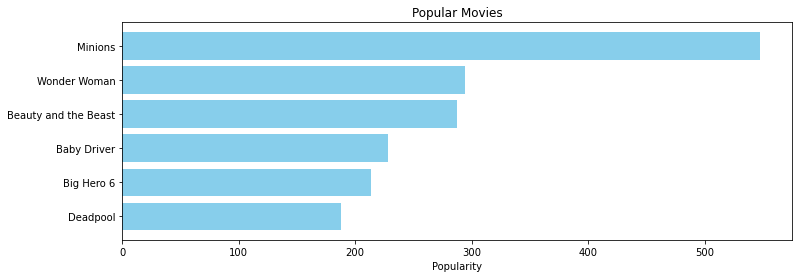

In [4]:
pop= df_movies.sort_values('popularity', ascending=False)

plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")


<h3> Recomendação baseada na descrição do filme </h3>

In [5]:
tfidf = TfidfVectorizer(stop_words='english')
df_movies['overview'] = df_movies['overview'].fillna('')
tfidf_matrix = tfidf.fit_transform(df_movies['overview'])
tfidf_matrix.shape

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
indices = pd.Series(df_movies.index, index=df_movies['title']).drop_duplicates()


In [6]:
getRecommendations('Taxi Driver',cosine_sim)

21114                      Take Me Home
14431                   99 River Street
28851                  Among the Living
35855                            Diablo
15195                      Chained Heat
2593                 My Son the Fanatic
14155                      Goodbye Solo
1851                    Midnight Cowboy
3292     We're Back! A Dinosaur's Story
28991                            Schizo
Name: title, dtype: object

<h3> Recomendação baseada nos metadados (palavras-chaves, elenco e diretor)</h3>


In [7]:
df_keywords['id'] = df_keywords['id'].astype('string')

df_movies = df_movies.merge(df_keywords, on='id')
links_small.columns =['movieid','imdbId','id']
links_small.dropna(inplace=True)
links_small['id'] = links_small['id'].astype('int')
links_small['id'] = links_small['id'].astype('string')

df_linksmall_movies = df_movies.merge(links_small, on='id',how = 'inner')
df_linksmall_movies['cast'] = df_linksmall_movies['cast'].apply(literal_eval)
df_linksmall_movies['crew'] = df_linksmall_movies['crew'].apply(literal_eval)
df_linksmall_movies['keywords'] = df_linksmall_movies['keywords'].apply(literal_eval)
df_linksmall_movies['cast_size'] = df_linksmall_movies['cast'].apply(lambda x: len(x))
df_linksmall_movies['crew_size'] = df_linksmall_movies['crew'].apply(lambda x: len(x))

df_linksmall_movies['cast'] = df_linksmall_movies['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df_linksmall_movies['cast'] = df_linksmall_movies['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)
df_linksmall_movies['cast'] = df_linksmall_movies['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

df_linksmall_movies['keywords'] = df_linksmall_movies['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

df_linksmall_movies['director'] = df_linksmall_movies['crew'].apply(getDirector)
df_linksmall_movies['director'] = df_linksmall_movies['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
df_linksmall_movies['director'] = df_linksmall_movies['director'].apply(lambda x: [x,x, x])

y = df_linksmall_movies.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
y.name = 'keyword'

y = y.value_counts()
y = y[y > 1]

stemmer = nltk.stem.SnowballStemmer('english')

def filterKeywords(x):
    words = []
    for i in x:
        if i in y:
            words.append(i)
    return words

df_linksmall_movies['keywords'] = df_linksmall_movies['keywords'].apply(filterKeywords)
df_linksmall_movies['keywords'] = df_linksmall_movies['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
df_linksmall_movies['keywords'] = df_linksmall_movies['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
df_linksmall_movies['soup'] = df_linksmall_movies['keywords'] + df_linksmall_movies['cast'] + df_linksmall_movies['director']
df_linksmall_movies['soup'] = df_linksmall_movies['soup'].apply(lambda x: ' '.join(x))

count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(df_linksmall_movies['soup'])

cosine_sim = cosine_similarity(count_matrix, count_matrix)

df_linksmall_movies = df_linksmall_movies.reset_index()
titles = df_linksmall_movies['title']
indices = pd.Series(df_linksmall_movies.index, index=df_linksmall_movies['title'])

C:\Users\JULIAN~1.PER\AppData\Local\Temp/ipykernel_3308/2974363026.py:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y = df_linksmall_movies.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)


In [8]:
getRecommendations('Star Wars',cosine_sim)

6199            Raising Victor Vargas
2120               Young and Innocent
4137                 The Gleaners & I
4789                     Donnie Darko
970                A Farewell to Arms
2705    An American Werewolf in Paris
983                      Maximum Risk
8865                  Gates of Heaven
7088                          Distant
8713     The Heart Is a Lonely Hunter
Name: title, dtype: object